<a href="https://colab.research.google.com/github/rigonzal/ANN/blob/master/Approach2/Pregunta_2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF-395 Redes Neuronales Artificiales
## Tarea 2 - Redes Neuronales

### Integrantes:
* Ignacio Valenzuela Albornoz 2014073055-1
* Rodrigo González Smith 201303026-2

# Desarrollo

Antes de proceder a realizar el trabajo importamos las librerías y paquetes que usaremos:

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import keras.backend as K
import keras
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import TerminateOnNaN
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler

%matplotlib inline

## Introducción

En esta ocasión aplicaremos el Transfer Learning, el cuál es una técnica que consiste en tomar una red ya entrenada y aplicarla para otro problema de características similares. Hay muchas formas de preparar esta red para realizar el transfer learning. En esta pregunta específicamente, se procederá a "congelar" las primeras capas de una red ya establecida y no entrenar sus pesos. Respecto al dataset, se usará al famoso CIFAR10, dataset de imágenes.

###  2.a. Análisis aplicando red convolucional

Primero que todo comenzaremos a importar el dataset de las imágenes, normalizar el dataset y convertir las etiquetas en *one hot vector*, para así evitar inconsistencias entre labels.

In [0]:
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes=100)
y_test = keras.utils.to_categorical(y_test, num_classes=100)
x_train_norm = x_train/255.0
x_test_norm = x_test/255.0

Comenzaremos a entrenar la red convolucional durante 15 epochs.

In [44]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)              0         
__________

In [45]:
optimizer_ = SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
history = model.fit(x_train_norm, y_train, batch_size=128,epochs=15,verbose=1, validation_data=(x_test_norm,y_test)) #train it

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 13s 264us/step - loss: 4.3580 - acc: 0.0413 - val_loss: 3.8997 - val_acc: 0.1066
Epoch 2/15
50000/50000 [==============================] - 12s 249us/step - loss: 3.8160 - acc: 0.1204 - val_loss: 3.5547 - val_acc: 0.1655
Epoch 3/15
50000/50000 [==============================] - 12s 244us/step - loss: 3.4840 - acc: 0.1769 - val_loss: 3.2913 - val_acc: 0.2137
Epoch 4/15
50000/50000 [==============================] - 12s 246us/step - loss: 3.1801 - acc: 0.2277 - val_loss: 2.9412 - val_acc: 0.2842
Epoch 5/15
50000/50000 [==============================] - 12s 245us/step - loss: 2.9090 - acc: 0.2812 - val_loss: 2.7575 - val_acc: 0.3205
Epoch 6/15
50000/50000 [==============================] - 12s 245us/step - loss: 2.6653 - acc: 0.3290 - val_loss: 2.6157 - val_acc: 0.3512
Epoch 7/15
50000/50000 [==============================] - 12s 248us/step - loss: 2.4599 - acc: 0.3731 - val_loss: 2.

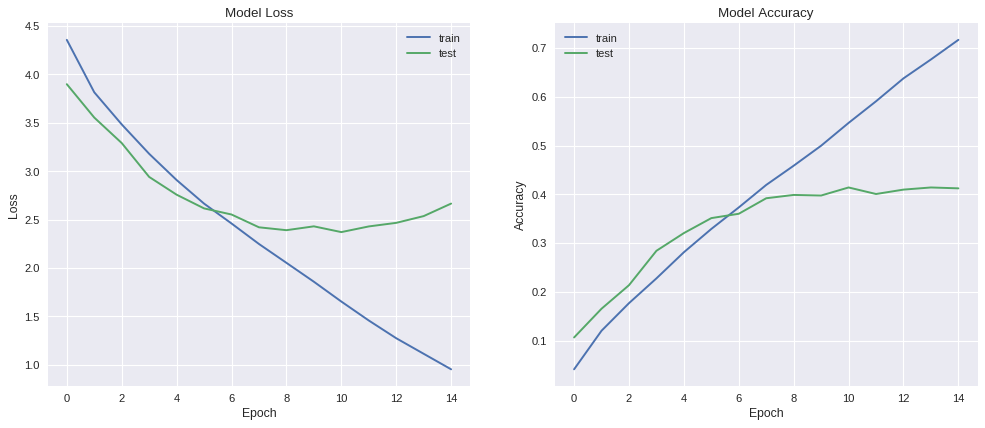

In [46]:
plt.figure(figsize=(15, 6), dpi=80, facecolor='w', edgecolor='b')
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

Como se puede apreciar, vemos presencia de overfitting. El loss de entrenamiento baja constantemente mientras que el de test se mantiene constante desde el sexto epoch. Esto nos hace ver que el modelo aprende muy bien el set de entrenamiento, pero al de test le cuesta y mantiene los mismos loss al pasar los epoch. También lo podemos ver en el gráfico de accuracy, donde vemos que también se estanca para el set de test.

Por otra parte, el tiempo de entrenamiento para el caso de CPU era demasiado alto, estimando un tiempo cercano a 4 minutos por cada epoch, pero al utilizar la GPU se redujo considerablemente, teniendo tiempos de cálculo de aproximadamente 11 [sg] por epoch, lo cual es una diferencia considerable. Por último, para ir comparando los distintos modelos de redes neuronale convolucionales que se irán creando, se calculará el accuracy del modelo final  sobre el conjunto de test.

In [47]:
test_loss, test_acc = model.evaluate(x_test_norm, y_test)

10000/10000 [==============================] - 2s 181us/step


In [48]:
print(test_acc)

0.4122


Podemos apreciar que el modelo arroja un valor de 0.4122 de accuracy, valor que al ver el gráfico concuerda. Ahora procederemos a utilizar el regulador Dropout para lograr reducir el overfitting del modelo, buscando que se disminuya el loss del set de test.

Antes de prodecer a ejecutar los modelos, es necesario analizar en que parte del modelo sería eficiente incluir un Dropout. Como el Dropout consiste en, dependiendo del valor del parámetro, "apagar" ciertas neuronas. En el caso de las redes feedforward esto ayudaba a reducir el overfitting ya que otras neuronas se encargaban de analizar ciertos valores que antes no recibían. 

En el caso de las redes convolucionales, en vez de apagar neuronas, estaríamos apagando ciertos filtros dentro de ella. Como sabemos, los diversos filtros tras el entrenamiento, pueden estar analizando ciertos patrones de las imágenes de entrada, por lo que apagar ciertos filtros hará que los pertenecientes a otras capas tengan que analizar estos patrones, lo que agregará cierta información y una actualización diferente a los pesos.

Es por esto, que aplicar Dropout inmediatamente después de la primera capa convolucional no es recomendable. Esto es debido a que estos filtros del inicio deben reconocer esos patrones; si aplicamos Dropout, les será muy difícil definir bien esos patrones y aumentará el error. En cambio, si regulamos la segunda capa convolucional,  haremos que diversos filtros tomen la información y se adapten y obtendremos valores distintos los cuales, en cada epoch, nos podrían dar valores distintos en el MaxPooling, ya que este toma el valor mayor de cada grilla.

En resumen, aplicar Dropout luego de cada par de capas convolucionales nos ayudará a que estos filtros vayan variando en cada epoch y analizando diferentes patrones, los cuales nos variará gracias al MaxPooling. Esto hará que en cada época, ciertos patrones nos ofrecerán más información, la cual será heredada para las siguientes capas.

Ahora, para el caso experimental, se verá si será mejor aplicar este Dropout después del primer par, del segundo par o aplicarlo en ambos. Se aplicará los modelos para los 3 casos y se comprobará mediante una gráfica.

In [49]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
optimizer_ = SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
history1 = model.fit(x_train_norm, y_train, batch_size=128,epochs=15,verbose=1, validation_data=(x_test_norm,y_test)) #train it

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 15s 293us/step - loss: 4.3033 - acc: 0.0490 - val_loss: 4.0147 - val_acc: 0.1006
Epoch 2/15
50000/50000 [==============================] - 14s 276us/step - loss: 3.7516 - acc: 0.1271 - val_loss: 3.5565 - val_acc: 0.1767
Epoch 3/15
50000/50000 [==============================] - 14s 276us/step - loss: 3.4002 - acc: 0.1891 - val_loss: 3.2421 - val_acc: 0.2454
Epoch 4/15
50000/50000 [==============================] - 14s 276us/step - loss: 3.0870 - acc: 0.2487 - val_loss: 3.0298 - val_acc: 0.2782
Epoch 5/15
50000/50000 [==============================] - 14s 275us/step - loss: 2.8248 - acc: 0.2979 - val_loss: 2.7997 - val_acc: 0.3214
Epoch 6/15
50000/50000 [==============================] - 14s 276us/step - loss: 2.5934 - acc: 0.3436 - val_loss: 2.6054 - val_acc: 0.3618
Epoch 7/15
50000/50000 [==============================] - 14s 276us/step - loss: 2.3679 - acc: 0.3923 - val_loss: 2.

In [50]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
optimizer_ = SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
history2 = model.fit(x_train_norm, y_train, batch_size=128,epochs=15,verbose=1, validation_data=(x_test_norm,y_test)) #train it

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 14s 283us/step - loss: 4.3326 - acc: 0.0479 - val_loss: 4.0232 - val_acc: 0.0891
Epoch 2/15
50000/50000 [==============================] - 13s 258us/step - loss: 3.7942 - acc: 0.1226 - val_loss: 3.6013 - val_acc: 0.1750
Epoch 3/15
50000/50000 [==============================] - 13s 260us/step - loss: 3.4490 - acc: 0.1803 - val_loss: 3.3191 - val_acc: 0.2274
Epoch 4/15
50000/50000 [==============================] - 13s 260us/step - loss: 3.1609 - acc: 0.2345 - val_loss: 2.9997 - val_acc: 0.2761
Epoch 5/15
50000/50000 [==============================] - 13s 258us/step - loss: 2.8949 - acc: 0.2831 - val_loss: 2.8232 - val_acc: 0.3245
Epoch 6/15
50000/50000 [==============================] - 13s 258us/step - loss: 2.6778 - acc: 0.3282 - val_loss: 2.6883 - val_acc: 0.3496
Epoch 7/15
50000/50000 [==============================] - 13s 260us/step - loss: 2.4705 - acc: 0.3702 - val_loss: 2.

In [51]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
optimizer_ = SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
historyboth = model.fit(x_train_norm, y_train, batch_size=128,epochs=15,verbose=1, validation_data=(x_test_norm,y_test)) #train it

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 15s 310us/step - loss: 4.3436 - acc: 0.0453 - val_loss: 4.0600 - val_acc: 0.1097
Epoch 2/15
50000/50000 [==============================] - 14s 288us/step - loss: 3.7910 - acc: 0.1207 - val_loss: 3.7615 - val_acc: 0.1630
Epoch 3/15
50000/50000 [==============================] - 14s 287us/step - loss: 3.4463 - acc: 0.1830 - val_loss: 3.3689 - val_acc: 0.2251
Epoch 4/15
50000/50000 [==============================] - 14s 287us/step - loss: 3.1305 - acc: 0.2390 - val_loss: 3.1649 - val_acc: 0.2836
Epoch 5/15
50000/50000 [==============================] - 14s 288us/step - loss: 2.8797 - acc: 0.2888 - val_loss: 2.9377 - val_acc: 0.3132
Epoch 6/15
50000/50000 [==============================] - 14s 289us/step - loss: 2.6560 - acc: 0.3347 - val_loss: 2.7607 - val_acc: 0.3463
Epoch 7/15
50000/50000 [==============================] - 15s 291us/step - loss: 2.4527 - acc: 0.3717 - val_loss: 2.

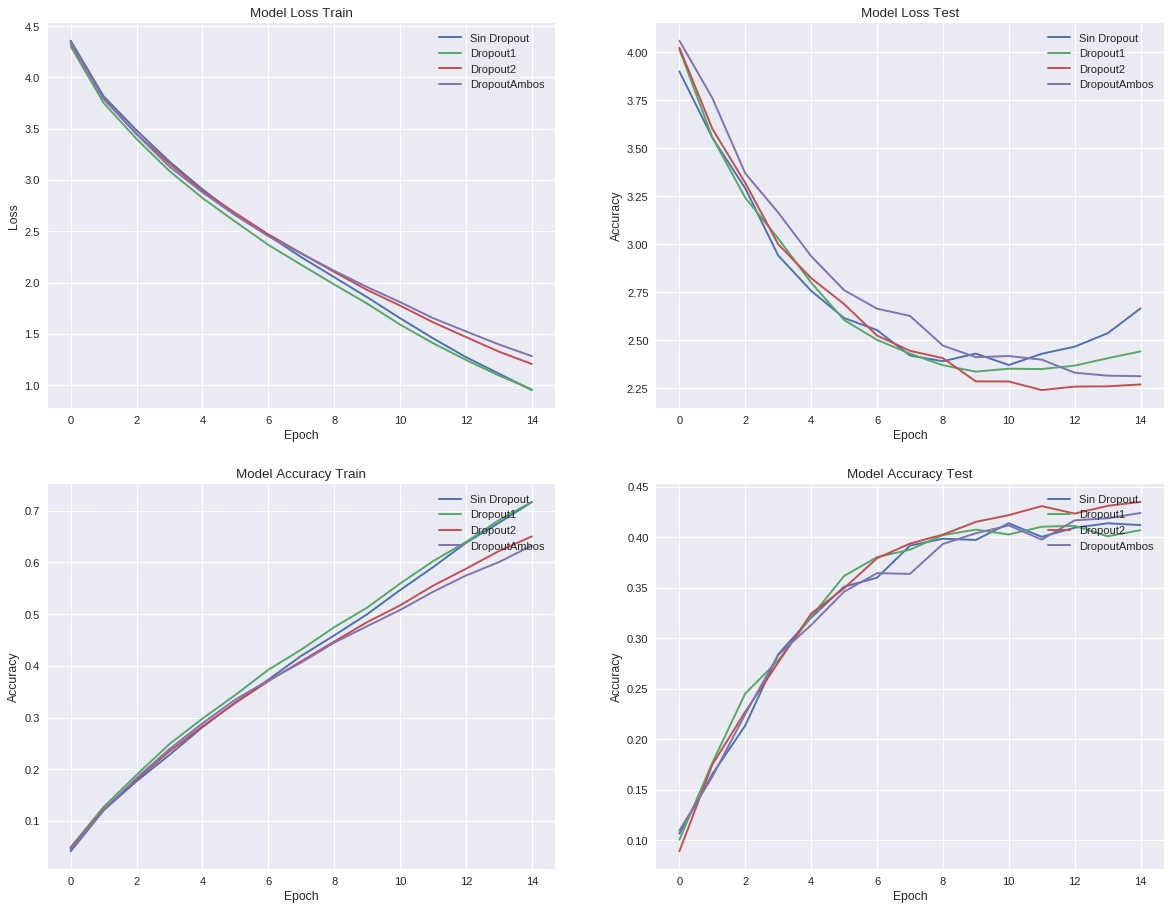

In [52]:
plt.figure(figsize=(18, 14), dpi=80, facecolor='w', edgecolor='b')
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(historyboth.history['loss'])
plt.title('Model Loss Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Sin Dropout', 'Dropout1', 'Dropout2', 'DropoutAmbos'], loc='upper right')

plt.subplot(2, 2, 2)
plt.plot(history.history['val_loss'])
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(historyboth.history['val_loss'])
plt.title('Model Loss Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Sin Dropout', 'Dropout1', 'Dropout2', 'DropoutAmbos'], loc='upper right')

plt.subplot(2, 2, 3)
plt.plot(history.history['acc'])
plt.plot(history1.history['acc'])
plt.plot(history2.history['acc'])
plt.plot(historyboth.history['acc'])
plt.title('Model Accuracy Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Sin Dropout', 'Dropout1', 'Dropout2', 'DropoutAmbos'], loc='upper right')

plt.subplot(2, 2, 4)
plt.plot(history.history['val_acc'])
plt.plot(history1.history['val_acc'])
plt.plot(history2.history['val_acc'])
plt.plot(historyboth.history['val_acc'])
plt.title('Model Accuracy Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Sin Dropout', 'Dropout1', 'Dropout2', 'DropoutAmbos'], loc='upper right')

plt.show()

Podemos apreciar que implementar Dropout en el primer par de capas covolucionales dio un mejor resultado. En general, aplicar Dropout después de estas capas dió mejor resultado que el modelo que no poseía Dropout. La razón de porque el Dropout al comienzo da mejores resultados puede recaer principalmente que hay mas datos que los filtros pueden convolucionar, aplicarlos en el segundo par poseemos una dimensión mas pequeña y ciertamente "descartada" por el MaxPooling ya que este almacena lo mejor de cada segmento, por lo que esa información que se perdió por MaxPooling podría haber dado cierta diferencia en los parámetros, por lo que se explica mejor que sea al comienzo el Dropout en vez del final. 

Por último, para comprobar que colocar el Dropout al comienzo o en otras posiciones, haremos un modelo con esa implementación.

In [53]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
optimizer_ = SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
historybad = model.fit(x_train_norm, y_train, batch_size=128,epochs=15,verbose=1, validation_data=(x_test_norm,y_test)) #train it

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 14s 276us/step - loss: 4.3750 - acc: 0.0402 - val_loss: 4.0111 - val_acc: 0.0953
Epoch 2/15
50000/50000 [==============================] - 13s 255us/step - loss: 3.8820 - acc: 0.1069 - val_loss: 3.6662 - val_acc: 0.1477
Epoch 3/15
50000/50000 [==============================] - 13s 255us/step - loss: 3.5991 - acc: 0.1518 - val_loss: 3.3640 - val_acc: 0.1942
Epoch 4/15
50000/50000 [==============================] - 13s 255us/step - loss: 3.3245 - acc: 0.2052 - val_loss: 3.1068 - val_acc: 0.2527
Epoch 5/15
50000/50000 [==============================] - 13s 255us/step - loss: 3.0593 - acc: 0.2511 - val_loss: 2.9502 - val_acc: 0.2836
Epoch 6/15
50000/50000 [==============================] - 13s 256us/step - loss: 2.8404 - acc: 0.2956 - val_loss: 2.7298 - val_acc: 0.3212
Epoch 7/15
50000/50000 [==============================] - 13s 254us/step - loss: 2.6325 - acc: 0.3358 - val_loss: 2.

A pesar de esto, no podemos ver diferencias muy grandes respecto al loss y accurate aplicando Dropout. Las diferencias son muy pocas, y aunque aplicar el Dropout de la forma que se obtienen mejores resultados, no hace mucha diferencia respecto a los que tienen Dropout mal ubicados o incluso del mismo modelo original, por lo que este regularizador no nos está reduciendo de forma considerable el overfitting.

Ahora, procederemos a realizar el Transfer Learning. Para eso, utilizaremos el modelo VGG16 proporcionado por la librería de keras para hacer este procedimiento. Importaremos el modelo y primero que todo veremos la arquitectura de este modelo sin modificar.

In [54]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.engine import Input
modelVGG = VGG16()
modelVGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Podemos apreciar que esta posee 23 capas, considerando las 3 últimas las cuales son la que transforma de convolucional a dense, y las tres capas dense del final. Vemos que la cantidad de parámetros que posee es muy grande: 138.357.544. Como nuestra idea es hacer un transfer learning, estas últimas tres capas debemos extraerlas del modelo, debido a que entrenaremos este nuevo modelo de tal forma que el output se adapte a nuestro problema con el dataset cifar. Procederemos a modificar este modelo para lograr ese cometido.

Para esto, realizaremos un pre-procesamiento de los datos de entrada ya que estos deben adaptarse a este nuevo modelo, el cual ocupaba el dataset de ImageNet. Los creadores de este modelo VGG, expresan en su paper que el único preprocesamiento que le hicieron a las imagenes de entrada fue restarle la media RGB a cada píxel, esta media obtenida respecto al conjunto de entrenamiento, por lo que procedemos a hacer este procesamiento despues de aplicar preprocess_input.

In [0]:
x_train_vgg = preprocess_input(x_train)
x_test_vgg = preprocess_input(x_test)

x_train_vgg = x_train_vgg - x_train_vgg.mean(axis=(0,1,2))
x_test_vgg = x_test_vgg - x_test_vgg.mean(axis=(0,1,2))

Luego, lo convertimos en un input_tensor para incluirlo dentro del modelo. Usamos los pesos de imagenet, asignamos el valor False a include_top para que nos remueva las capas densas del final del modelo y posteriormente sacamos las predicciones para cada muestra de set de entrenamiento y de test. Estas nuevas variables seran usadas posteriormente.

In [67]:
input_tensor=Input(shape=x_train_vgg.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor ) # LOAD PRETRAINED MODEL 
features_train = modelVGG.predict(x_train_vgg)
features_test = modelVGG.predict(x_test_vgg)
modelVGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

Las variables features_train y features_test son los valores que nos entrega este modelo sin considerar las capas densas del final. Esto debido a que debemos adaptar el problema a el nuestro, el cual posee solo 100 clases. Como es un transfer learning, lo aprendido por este modelo, y su output, será ocupado como entrada para otro modelo que se adapta a nuestro problema, y con esa información entrenar esta red para obtener resultados. Para eso, crearemos una red la cual inmediatamente aplica Flatten a la data de entrada para ocupar 2 capas densas que nos ayudará a aprender.

In [73]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
historyVGG = model.fit(features_train, y_train,epochs=10, batch_size=128,verbose=1,validation_data=(features_test,y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s 76us/step - loss: 14.6624 - acc: 0.0830 - val_loss: 14.5706 - val_acc: 0.0926
Epoch 2/10
50000/50000 [==============================] - 2s 50us/step - loss: 14.5412 - acc: 0.0956 - val_loss: 14.5544 - val_acc: 0.0953
Epoch 3/10
50000/50000 [==============================] - 2s 49us/step - loss: 14.5253 - acc: 0.0973 - val_loss: 14.5332 - val_acc: 0.0975
Epoch 4/10
50000/50000 [==============================] - 3s 51us/step - loss: 14.5375 - acc: 0.0971 - val_loss: 14.4900 - val_acc: 0.1007
Epoch 5/10
50000/50000 [==============================] - 3s 51us/step - loss: 14.5176 - acc: 0.0984 - val_loss: 14.4230 - val_acc: 0.1046
Epoch 6/10
50000/50000 [==============================] - 3s 52us/step - loss: 14.5255 - acc: 0.0980 - val_loss: 14.4813 - val_acc: 0.1012
Epoch 7/10
50000/50000 [==============================] - 3s 52us/step - loss: 14.5303 - acc: 0.0979 - val_loss: 14.

A primera vista vemos que el loss tanto de entrenamiento y test se disparan. Se verá mejor mediante un gráfico

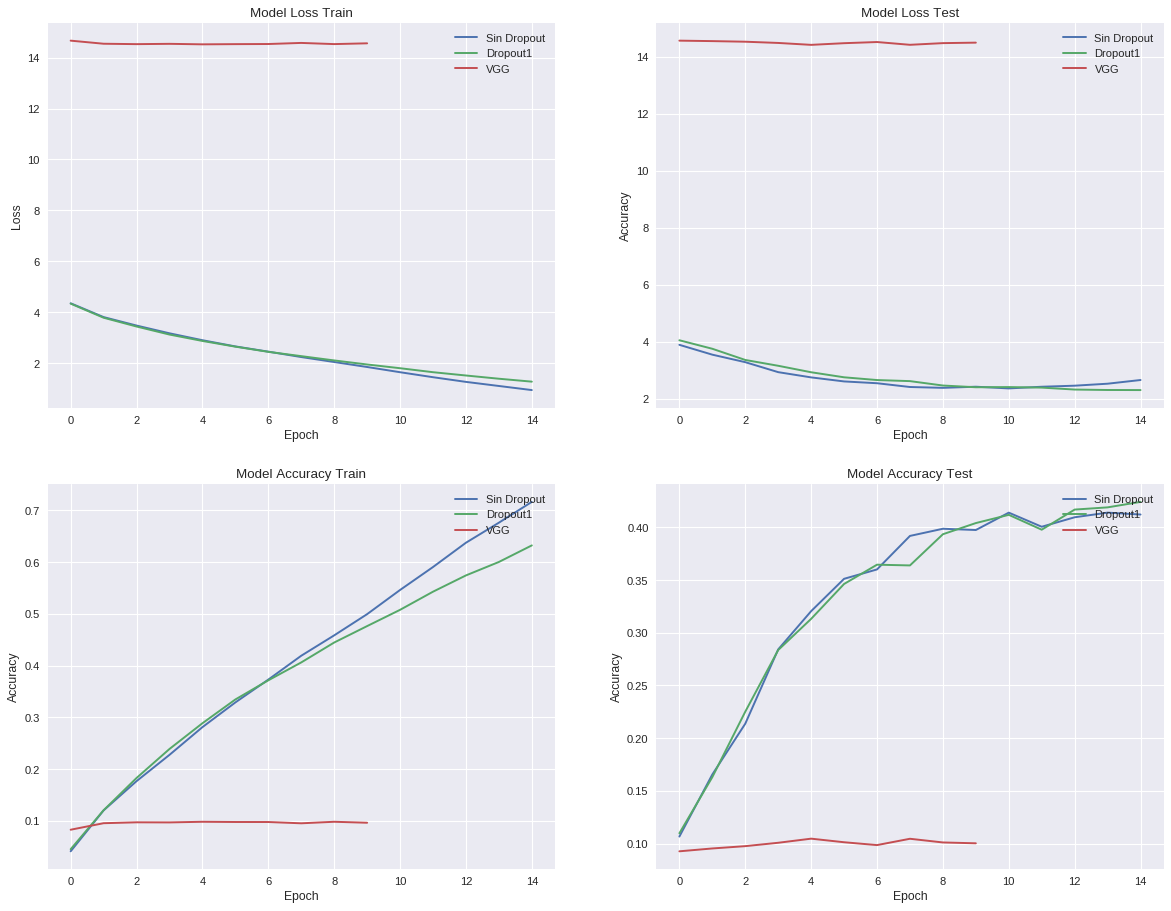

In [75]:
plt.figure(figsize=(18, 14), dpi=80, facecolor='w', edgecolor='b')
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(historyboth.history['loss'])
plt.plot(historyVGG.history['loss'])
plt.title('Model Loss Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Sin Dropout', 'Dropout1', 'VGG'], loc='upper right')

plt.subplot(2, 2, 2)
plt.plot(history.history['val_loss'])
plt.plot(historyboth.history['val_loss'])
plt.plot(historyVGG.history['val_loss'])
plt.title('Model Loss Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Sin Dropout', 'Dropout1', 'VGG'], loc='upper right')

plt.subplot(2, 2, 3)
plt.plot(history.history['acc'])
plt.plot(historyboth.history['acc'])
plt.plot(historyVGG.history['acc'])
plt.title('Model Accuracy Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Sin Dropout', 'Dropout1', 'VGG'], loc='upper right')

plt.subplot(2, 2, 4)
plt.plot(history.history['val_acc'])
plt.plot(historyboth.history['val_acc'])
plt.plot(historyVGG.history['val_acc'])
plt.title('Model Accuracy Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Sin Dropout', 'Dropout1', 'VGG'], loc='upper right')

plt.show()

Se puede apreciar el paupérrimo desempeño de la implementación del modelo VGG en el loss y accuracy en ambos conjuntos, lo que hace bastante injusto compararlo con los resultados obtenidos en los dos primeros modelos, el original y aplicando Dropout. 

Esto no significa que el transfer learning no funciona en este caso. Una razón primordial de porque el desempeño es tan bajo es que solo se estandarizaron los datos de entrada, que según el paper de los creadores de VGG era restar la media RGB. Aún así, falta la normalización de estos datos de entrada, ya que si no realizamos esto el error comienza a aumentar. Primero que todo los gradientes comienzan a ser mas variables durante el entrenamiento y, por consecuencia, una distribución interna de los pesos muy alta. 

Con este razonamiento, es una buena idea aplicar un método para normalizar los datos. En vez de realizarlo desde la entrada podemos realizar BatchNormalization entre las capas para que realize este proceso. Tras la idea de batchnormalization, debería ser esperable que la rápidez de convergencia sea mayor comparada a los modelos que no la implementan. Se hará el experimento con BatchNormalization.

In [71]:
from keras.layers import BatchNormalization

model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
historyBatch = model.fit(features_train, y_train,epochs=15, batch_size=128,verbose=1,validation_data=(features_test,y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 5s 106us/step - loss: 3.3133 - acc: 0.2699 - val_loss: 2.4337 - val_acc: 0.3893
Epoch 2/15
50000/50000 [==============================] - 4s 80us/step - loss: 2.4795 - acc: 0.3768 - val_loss: 2.3092 - val_acc: 0.4090
Epoch 3/15
50000/50000 [==============================] - 4s 83us/step - loss: 2.2499 - acc: 0.4150 - val_loss: 2.2448 - val_acc: 0.4233
Epoch 4/15
50000/50000 [==============================] - 4s 81us/step - loss: 2.1175 - acc: 0.4378 - val_loss: 2.2158 - val_acc: 0.4301
Epoch 5/15
50000/50000 [==============================] - 4s 83us/step - loss: 2.0042 - acc: 0.4593 - val_loss: 2.2024 - val_acc: 0.4357
Epoch 6/15
50000/50000 [==============================] - 4s 78us/step - loss: 1.9363 - acc: 0.4736 - val_loss: 2.2065 - val_acc: 0.4307
Epoch 7/15
50000/50000 [==============================] - 4s 78us/step - loss: 1.8729 - acc: 0.4855 - val_loss: 2.1835 - val_ac

Vemos ahora que el modelo si nos presenta valores de loss y accuracy más deseables, comparados a los obtenidos en los modelos anteriores. Realizaremos una gráfica comparando test y entrenamiento para este modelo.

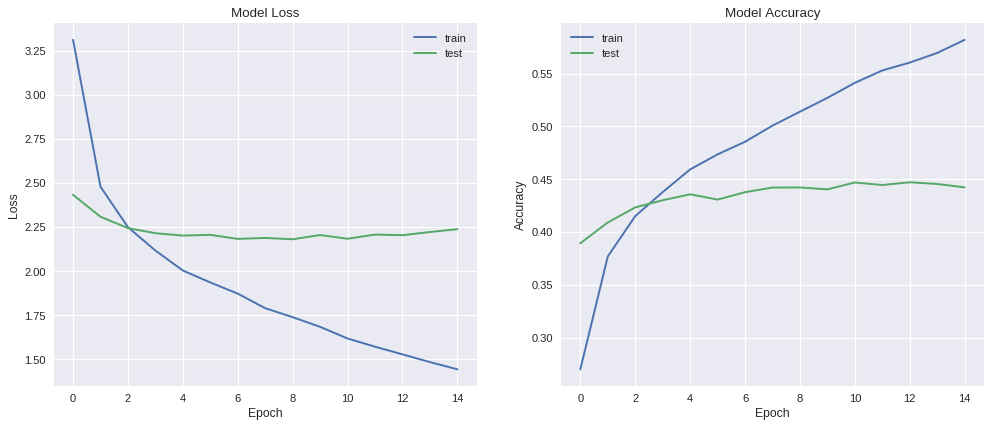

In [77]:
plt.figure(figsize=(15, 6), dpi=80, facecolor='w', edgecolor='b')
plt.subplot(1, 2, 1)
plt.plot(historyBatch.history['loss'])
plt.plot(historyBatch.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(historyBatch.history['acc'])
plt.plot(historyBatch.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

Como se ve en la gráfica, obtenemos buenos valores para ambos set pero seguimos en presencia de overfitting. Ahora realizando una grafica comparando con los otros modelos:

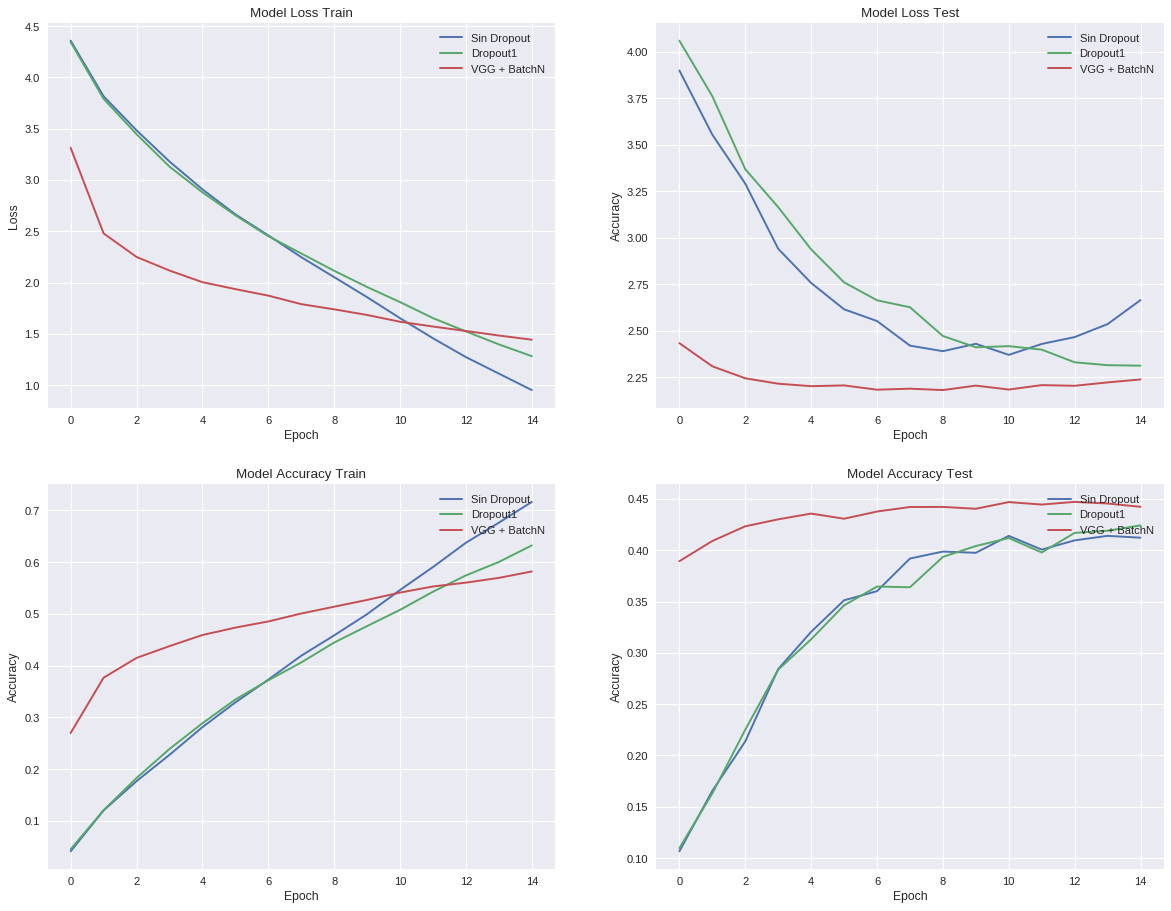

In [76]:
plt.figure(figsize=(18, 14), dpi=80, facecolor='w', edgecolor='b')
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(historyboth.history['loss'])
plt.plot(historyBatch.history['loss'])
plt.title('Model Loss Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Sin Dropout', 'Dropout1', 'VGG + BatchN'], loc='upper right')

plt.subplot(2, 2, 2)
plt.plot(history.history['val_loss'])
plt.plot(historyboth.history['val_loss'])
plt.plot(historyBatch.history['val_loss'])
plt.title('Model Loss Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Sin Dropout', 'Dropout1', 'VGG + BatchN'], loc='upper right')

plt.subplot(2, 2, 3)
plt.plot(history.history['acc'])
plt.plot(historyboth.history['acc'])
plt.plot(historyBatch.history['acc'])
plt.title('Model Accuracy Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Sin Dropout', 'Dropout1', 'VGG + BatchN'], loc='upper right')

plt.subplot(2, 2, 4)
plt.plot(history.history['val_acc'])
plt.plot(historyboth.history['val_acc'])
plt.plot(historyBatch.history['val_acc'])
plt.title('Model Accuracy Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Sin Dropout', 'Dropout1', 'VGG + BatchN'], loc='upper right')

plt.show()

Como se puede apreciar, el modelo VGG con batch obtiene mejores resultados. Por la parte de entrenamiento se ve que converge mas rápido un punto pero luego no comienza a disminuir tanto como los otros modelos, por lo que podríamos ver una pequeña disminución del overfitting ya que se nota que comienza a tomar un valor mas constante. Por la parte de test la diferencia es mucho mas notoria, donde obtiene valores "óptimos" mas rápidamente comparado con los otros modelos, en la segunda epoch ya obtiene valores mejores que los anteriores modelos, por lo que usar este método nos ayudará a converger más rápido a los valores de loss y acc para el conjunto de test.

# Conclusión

En general, vemos que transfer learning es un buen método de optimización cuando, al implementar un modelo para un problema específico este no posee un buen desempeño, por lo que aprovechar un modelo mas general y que da mejores resultados puede ayudar a reducir tiempo de entrenamiento.

Respecto al uso del transfer learning podemos encontrar dos beneficios de cuando usarlos:

  - El primero es cuando nuestro modelo no posee una cantidad grande de datos para poder entrenarlo de forma adecuada y así obtener un buen desempeño. Gracias al transfer learning, podemos ocupar un modelo de propósito general que haya sido entrenado con una masiva cantidad de datos, lo que implicaría un mejor desempeño. Por lo tanto, se eliminaría esa incapacidad de entrenar un modelo debido a la falta de datos de entrenamiento.
  
  - El segundo claramente es que mejora el desempeño tanto de los valores que se pueden conseguir respecto a loss y accuracy como también al tiempo de convergencia, probablemente necesite menos epoch para converger (sobre todo si se aplica batchnormalization cuando se debe) lo que implica en menor tiempo de entrenamiento. 
  
  La única desventaja del transfer learning es que la única forma de comprobar si es una buena idea es implementando y comparando los resultados, no hay algún indicio previo. Eso si, al comprobar los resultados, nos podemos fijar en tres factores importantes para hacer la decisión final de cual modelo escoger:
    
    1.   Analizar el punto de partida. Desde la primera epoch, analizar si los valores de loss y accuracy son mejor que la del modelo anterior. Un buen punto de partida implica que el modelo obtendrá una ventaja inicial respecto al otro modelo.
    2.   El ratio de mejora es mejor que el modelo anterior. Eso se implicará en una menos pronunciada (dependiendo si analizamos loss o accuracy, hacia abajo y arriba respectivamente) lo que implica que el modelo tiene mejor desempeño a través de las epoch que el modelo anterior.
    3.   Por último, analizar el valor de convergencia. Será un buen factor que el valor de convergencia del modelo con transfer learning sea mejor que el modelo anterior.
    
  Tras analizar esos tres puntos y si cumple con esos, será siempre mejor opción optar por el modelo de transfer learning y tras eso probar intentar cambiar hiperparámetros u la inclusión o eliminación de capas o regularizadores. 
  Cabe destacar que no cualquier modelo puede "heredar" a otro mediante el transfer learning, hay que analizar que los problemas tengan cierta similitud y que el modelo "padre" tenga features de carácter general y no tan específicos al problema en sí.

